In [1]:
import pandas as pd
import numpy as np
import os
from os.path import exists
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
sns.set_theme(style="dark")

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [2]:
CO2_URL = "https://gml.noaa.gov/aftp/products/trends/co2/co2_annmean_gl.csv"
CO2_FILENAME = "noaa_co2.csv"
OCEAN_HEAT_URL = "https://www.ncei.noaa.gov/data/oceans/woa/DATA_ANALYSIS/3M_HEAT_CONTENT/DATA/basin/3month/ohc_levitus_climdash_seasonal.csv"
# https://www.ncei.noaa.gov/access/global-ocean-heat-content/basin_heat_data_monthly.html
OCEAN_HEAT_FILENAME = "ncei_global_ocean_heat.csv"

In [3]:
def process_ocean_heat(data_path="../data"):
    if not exists(data_path):
        os.makedirs(data_path)

    if not os.path.isfile(os.path.join(data_path, OCEAN_HEAT_FILENAME)):
        df_ocean = pd.read_csv(OCEAN_HEAT_URL)
        df_ocean.rename(columns={"YEAR": "Date", "WO": "Temp"}, inplace=True)
        df_ocean.Date = pd.to_datetime(df_ocean.Date)
        df_ocean.set_index("Date", inplace=True)
        df_ocean.to_csv(os.path.join(data_path, OCEAN_HEAT_FILENAME))

    else:
        df_ocean = pd.read_csv(
            os.path.join(data_path, OCEAN_HEAT_FILENAME),
            index_col=["Date"],
            parse_dates=True,
        )

    return df_ocean

In [4]:
def process_co2(data_path="../data"):
    if not exists(data_path):
        os.makedirs(data_path)

    if not os.path.isfile(os.path.join(data_path, CO2_FILENAME)):
        df_co2 = pd.read_csv(CO2_URL, skiprows=37)
        df_co2['month'] = 1
        df_co2['day'] = 1
        df_co2['Date'] = pd.to_datetime(df_co2[['year', 'month', 'day']])
        df_co2.set_index("Date", inplace=True)
        df_co2.rename(columns={"mean": "co2"}, inplace=True)
        df_co2 = df_co2[["co2"]]
        df_co2.to_csv(os.path.join(data_path, CO2_FILENAME))

    else:
        df_co2 = pd.read_csv(
            os.path.join(data_path, CO2_FILENAME), index_col=["Date"], parse_dates=True
        )

    return df_co2

In [5]:
df_ocean = process_ocean_heat()

In [6]:
df_co2 = process_co2()

## Ocean Heat

First we are converting from quarterly to annual data.

<Axes: xlabel='Date'>

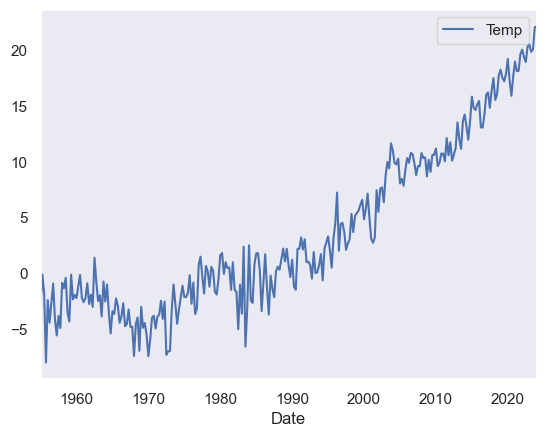

In [7]:
df_ocean.plot()

In [8]:
df_ocean = df_ocean.resample('YE').mean()
df_ocean.reset_index(inplace=True)
df_ocean['Date'] = df_ocean['Date'] + pd.offsets.YearBegin()
df_ocean.set_index("Date", inplace=True)
df_ocean = df_ocean.iloc[1:] #Dropping first column with incomplete data

<Axes: xlabel='Date'>

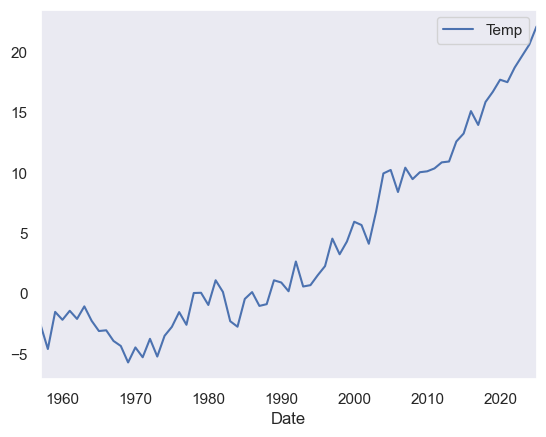

In [9]:
df_ocean.plot()

Like our reference paper, we will be taking the mean ocean temperature from 1970 to 2000 as our base period.

In [10]:
print(df_ocean.loc['1970-01-01':'1999-01-01'].mean())

Temp   -0.477019
dtype: float64


In [11]:
df_oceanb = df_ocean - df_ocean.loc['1970-01-01':'1999-01-01'].mean()

In [12]:
df_oceanb_diff = df_oceanb['Temp'].diff().dropna()

<Axes: xlabel='Date'>

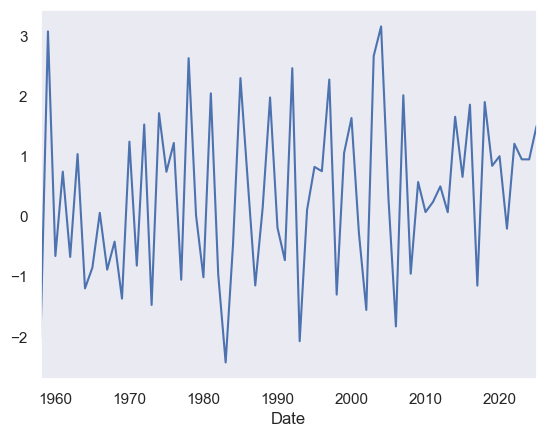

In [13]:
df_oceanb_diff.plot()

Taking first differences, we find that our result is stationary.

In [14]:
adf_result = adfuller(df_oceanb_diff)
print("ADF Statistic: ", adf_result[0])
print("p-value: ", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic:  -2.9531826058483635
p-value:  0.03950393950968663
Critical Values:
   1%: -3.53692771987915
   5%: -2.907887369384766
   10%: -2.591493291015625


There is however one significant autocorrelation lag.

In [15]:
# Fit ARIMA model (0, 2, 1) - 1 AR terms, differencing order 2, and 0 MA terms
model = ARIMA(df_oceanb, order=(1, 1, 2))
model_fit = model.fit()

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [16]:
# Print the model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   Temp   No. Observations:                   69
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -114.059
Date:                Sun, 16 Jun 2024   AIC                            236.119
Time:                        18:55:22   BIC                            244.997
Sample:                    01-01-1957   HQIC                           239.637
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9898      0.060     16.452      0.000       0.872       1.108
ma.L1         -1.3288      0.153     -8.690      0.000      -1.629      -1.029
ma.L2          0.3826      0.122      3.123      0.0

In [17]:
# Step 5: Forecasting
forecast_steps = 10  # Number of future years to forecast
forecast = model_fit.forecast(steps=forecast_steps)

# Forecast index for plotting
forecast_index = pd.date_range(start=df_oceanb.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='YS')

# Get the fitted values from the model (in-sample predictions)
fitted_values = model_fit.fittedvalues

We can see that our SARIMAX model fits the data well, the first year is when there is not enough data to do first order differencing so the model is incomplete. Additionally, we have predicted the next 10 years of data. These are linear because the most recent decade has been linear.

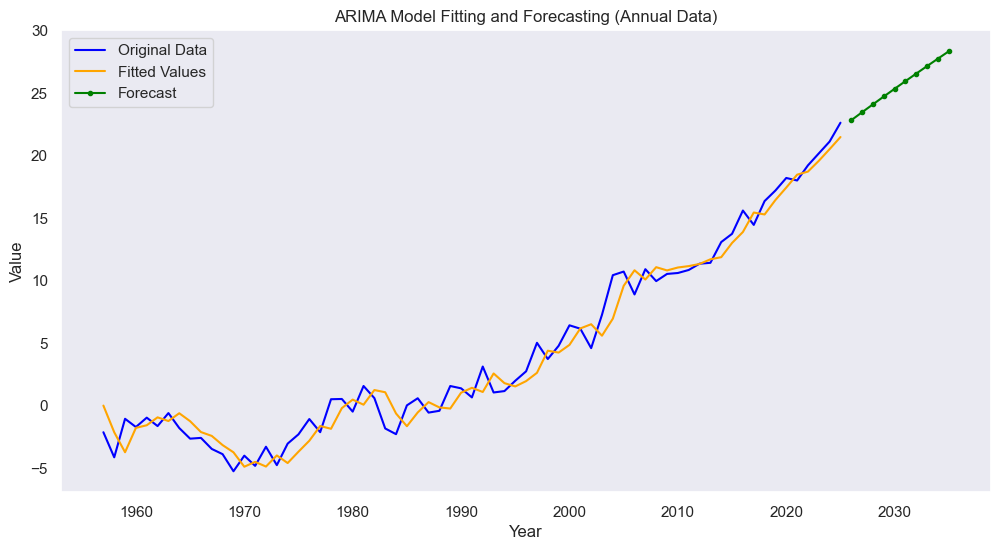

In [18]:
# Plot original data, fitted values, and forecast
plt.figure(figsize=(12, 6))
plt.plot(df_oceanb, label='Original Data', color='blue')
plt.plot(df_oceanb.index, fitted_values, label='Fitted Values', color='orange')
plt.plot(forecast_index, forecast, label='Forecast', color='green', marker='.')
plt.title('ARIMA Model Fitting and Forecasting (Annual Data)')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

Despite the run in the late 60s, there does not appear to be a problem with autocorrelation in residuals:

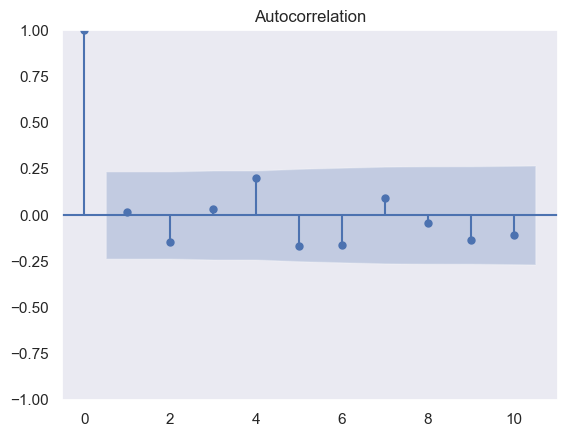

In [19]:
plot_acf(model_fit.resid, lags=10, alpha=0.05)
plt.show()

Plotting the residuals of our model, we see that the residuals follow a roughly normal distribution symmetrical about zero.

<Axes: >

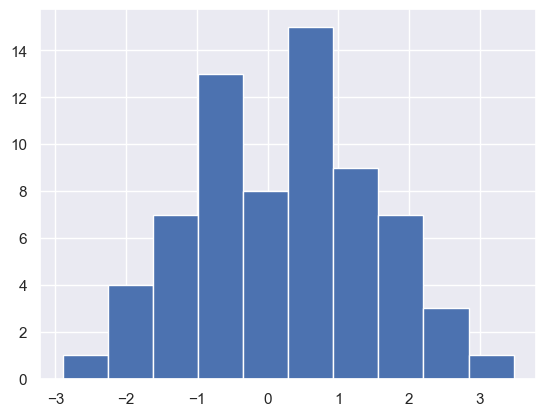

In [20]:
model_fit.resid.iloc[1:].hist(bins=10)

## CO2

<Axes: xlabel='Date'>

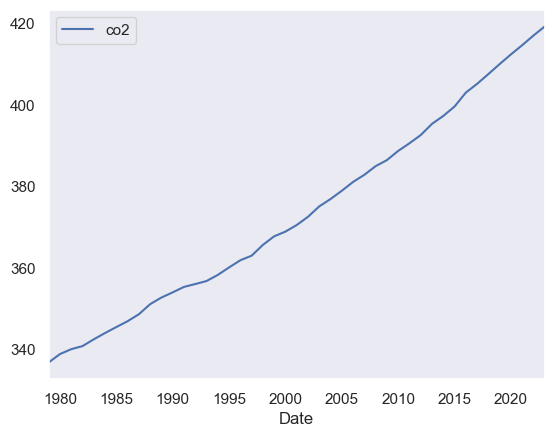

In [21]:
df_co2.plot()

<Axes: xlabel='Date'>

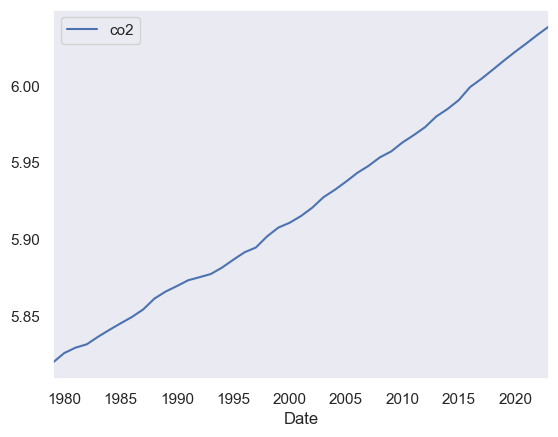

In [22]:
np.log(df_co2).plot()

In the paper they are taking the difference from 1970, since our dataset starts in 1979 we are taking the mean of the first five years of our sample.

In [23]:
df_co2.loc['1979-01-01':'1983-01-01'].mean()

co2    339.852
dtype: float64

In [24]:
df_co2b = df_co2 - df_co2.loc['1979-01-01':'1983-01-01'].mean()

<Axes: xlabel='Date'>

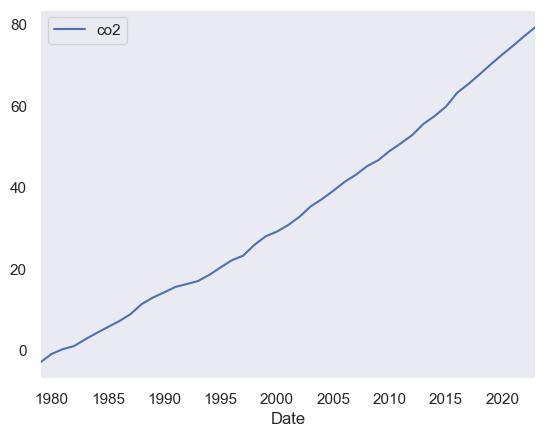

In [25]:
df_co2b.plot()

Next, let's look at annual change.

In [26]:
df_co2b_diff = df_co2b.diff().dropna()

We can see that it is not stationary, the rate of increase in $CO_2$ concentration has increased. Counter to our original graph, we now see that $CO_2$ is not linear.

<Axes: xlabel='Date'>

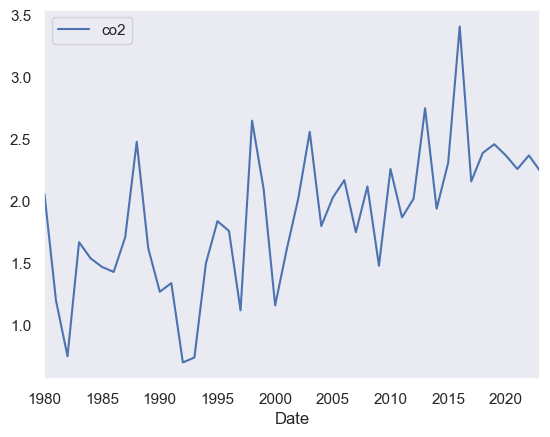

In [27]:
df_co2b_diff.plot()

There is a high degree of autocorrelation. Note the first 11 lags are all positively correlated.

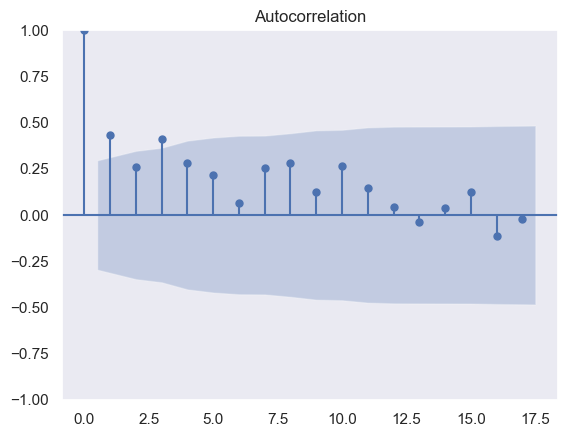

In [28]:
plot_acf(df_co2b_diff['co2'])
plt.show()

In [29]:
df_co2b_diff2 = df_co2b_diff.diff().dropna()

Taking second differences, we have achieved stationarity. This suggests a quadratic equation to fit our original data.

<Axes: xlabel='Date'>

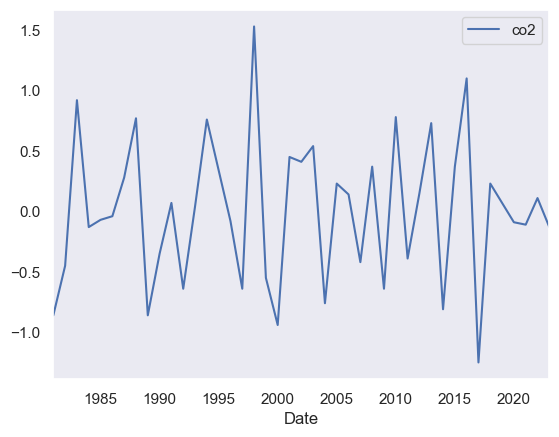

In [30]:
df_co2b_diff2.plot()

In [31]:
adf_result = adfuller(df_co2b_diff2)
print("ADF Statistic: ", adf_result[0])
print("p-value: ", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic:  -9.141882316992314
p-value:  2.8348448435740223e-15
Critical Values:
   1%: -3.60098336718852
   5%: -2.9351348158036012
   10%: -2.6059629803688282


We still see an autocorrelation effect with a reverse in sign in the first lag. For modeling out data we will use an ARIMA equation with one lag.

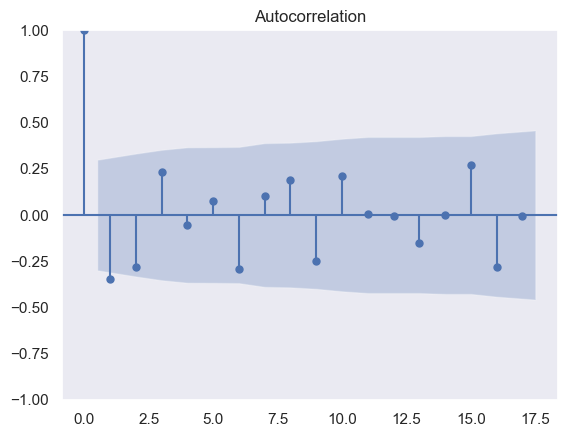

In [32]:
plot_acf(df_co2b_diff2['co2'])
plt.show()

In [33]:
# Fit ARIMA model (0, 2, 1) - 1 AR terms, differencing order 2, and 0 MA terms
model = ARIMA(df_co2b, order=(1, 2, 0))
model_fit = model.fit()

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [34]:
# Print the model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                   45
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 -36.179
Date:                Sun, 16 Jun 2024   AIC                             76.358
Time:                        18:55:23   BIC                             79.881
Sample:                    01-01-1979   HQIC                            77.657
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3530      0.152     -2.325      0.020      -0.651      -0.055
sigma2         0.3140      0.074      4.221      0.000       0.168       0.460
Ljung-Box (L1) (Q):                   1.11   Jarque-

In [35]:
# Step 5: Forecasting
forecast_steps = 10  # Number of future years to forecast
forecast = model_fit.forecast(steps=forecast_steps)

# Forecast index for plotting
forecast_index = pd.date_range(start=df_co2b.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='YS')

# Get the fitted values from the model (in-sample predictions)
fitted_values = model_fit.fittedvalues

We can see that our SARIMAX model fits the data well, the first two years are when there is not enough data to do second order differencing so the model is incomplete. Additionally, we have predicted the next 10 years of data. These are linear (despite the previous data being quadratic) because the most recent several years have been linear. This continues the trend from the last five years.

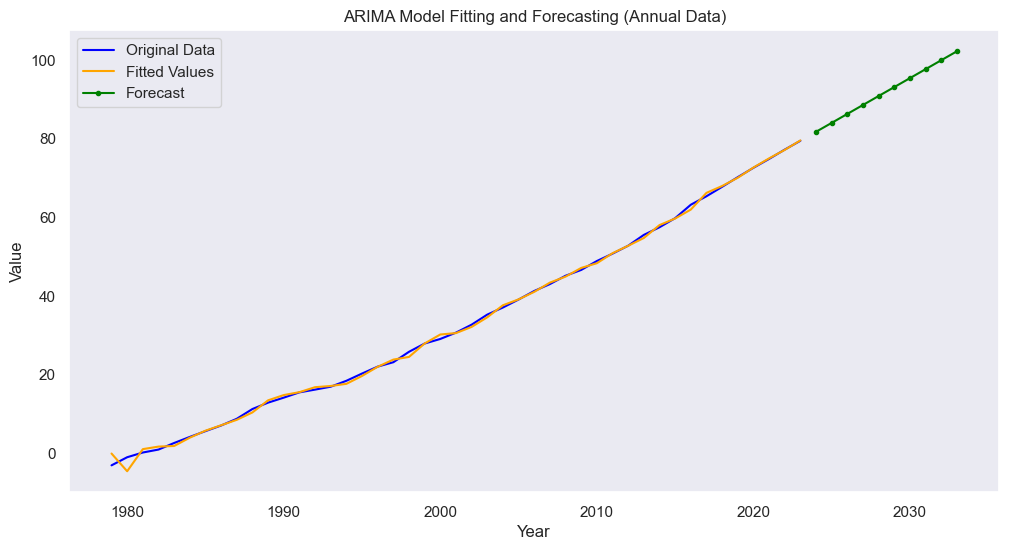

In [36]:
# Plot original data, fitted values, and forecast
plt.figure(figsize=(12, 6))
plt.plot(df_co2b, label='Original Data', color='blue')
plt.plot(df_co2b.index, fitted_values, label='Fitted Values', color='orange')
plt.plot(forecast_index, forecast, label='Forecast', color='green', marker='.')
plt.title('ARIMA Model Fitting and Forecasting (Annual Data)')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

Plotting the residuals of our model (excluding the first two years), we see that it is often very accurate to predicting the following year's $co_2$ level, however the remaining residuals are quite distributed. Notably, all of our predicted values are with +-1 PPM of the actual PPM concentration.

<Axes: >

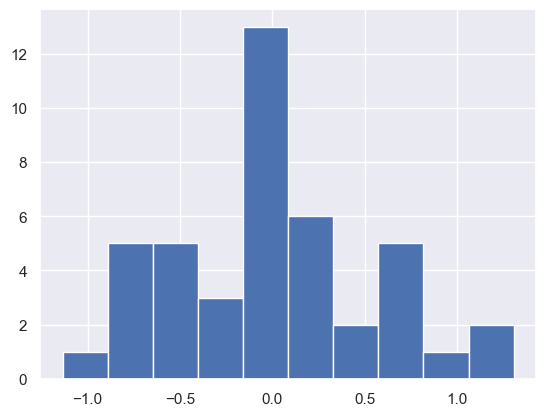

In [37]:
model_fit.resid.iloc[2:].hist(bins=10)

We can see that there is leptokurtic and has a slight positive skew.

## Both together

In [38]:
merged_df = pd.merge(df_oceanb, df_co2b, on='Date')
merged_df.dropna(inplace=True)

<Axes: xlabel='Date'>

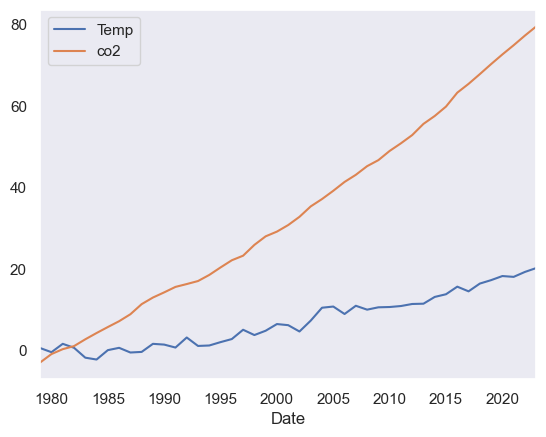

In [39]:
merged_df.plot()

There is not an interesting relationship between the two because both are increasing over time:

<Axes: xlabel='Temp', ylabel='co2'>

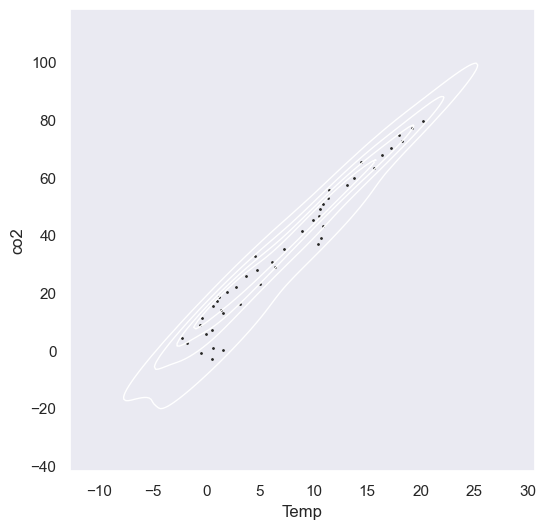

In [40]:
x = merged_df['Temp']
y = merged_df['co2']

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

Additionally, when taking first differences again we do not see a relationship:

In [41]:
merged_df['Temp_diff'] = merged_df['Temp'].diff()
merged_df['co2_diff'] = merged_df['co2'].diff()

<Axes: xlabel='Temp_diff', ylabel='co2_diff'>

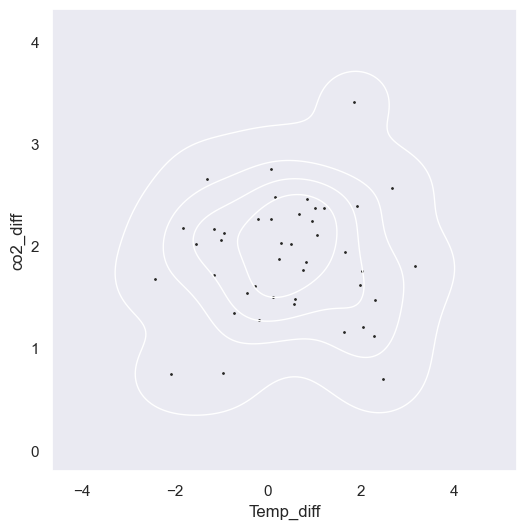

In [42]:
x = merged_df['Temp_diff']
y = merged_df['co2_diff']

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)